# Case Study #1

## Setup

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px

import warnings
warnings.filterwarnings('ignore')

# import plotly.io as pio
# pio.renderers.default='notebook'

In [2]:
raw_df = pd.read_csv('./loans_full_schema.csv')

In [3]:
pd.set_option('display.max_columns', None)
raw_df.sample(5)

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,delinq_2y,months_since_last_delinq,earliest_credit_line,inquiries_last_12m,total_credit_lines,open_credit_lines,total_credit_limit,total_credit_utilized,num_collections_last_12m,num_historical_failed_to_pay,months_since_90d_late,current_accounts_delinq,total_collection_amount_ever,current_installment_accounts,accounts_opened_24m,months_since_last_credit_inquiry,num_satisfactory_accounts,num_accounts_120d_past_due,num_accounts_30d_past_due,num_active_debit_accounts,total_debit_limit,num_total_cc_accounts,num_open_cc_accounts,num_cc_carrying_balance,num_mort_accounts,account_never_delinq_percent,tax_liens,public_record_bankrupt,loan_purpose,application_type,loan_amount,term,interest_rate,installment,grade,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
1221,director of operations,2.0,IL,MORTGAGE,91000.0,Source Verified,19.57,NaN,NaN,NaN,0,NaN,2006,1,27,8,392003,46564,0,0,NaN,0,0,3,6,1.0,8,0.0,0,3,24100,15,4,4,2,100.0,0,0,credit_card,individual,32000,60,11.98,711.50,B,B5,Mar-2018,Current,whole,Cash,30812.11,2059.96,1187.89,872.07,0.0
1460,naval officer (future operations),10.0,VA,OWN,120000.0,Source Verified,16.11,NaN,NaN,NaN,0,43.0,1989,0,25,13,496784,90819,0,0,NaN,0,0,1,2,19.0,13,0.0,0,3,65000,15,11,8,4,96.0,0,0,other,individual,3000,36,10.90,98.08,B,B4,Mar-2018,Current,whole,Cash,2785.57,292.42,214.43,77.99,0.0
6395,NaN,NaN,NY,RENT,22848.0,Verified,16.86,NaN,NaN,NaN,0,NaN,1975,2,35,18,37200,9006,0,1,NaN,0,0,0,7,6.0,17,0.0,0,1,16000,34,18,7,0,100.0,0,1,debt_consolidation,individual,9500,36,7.35,294.86,A,A4,Jan-2018,Current,fractional,Cash,7977.27,1802.98,1522.73,280.25,0.0
3814,police officer,3.0,CT,MORTGAGE,100000.0,Not Verified,18.00,NaN,NaN,NaN,0,25.0,2008,2,25,10,320952,65989,0,0,NaN,0,0,5,3,8.0,10,0.0,0,3,12500,7,4,3,1,92.0,0,0,debt_consolidation,individual,40000,60,15.05,952.65,C,C4,Jan-2018,Late (16-30 days),whole,Cash,38630.01,2824.51,1369.99,1454.52,0.0
8536,road driver,10.0,AL,MORTGAGE,110000.0,Not Verified,7.93,NaN,NaN,NaN,0,NaN,1995,1,29,6,120029,29493,0,0,NaN,0,0,1,4,10.0,6,0.0,0,1,7400,18,4,2,2,100.0,0,0,debt_consolidation,individual,17000,36,6.72,522.74,A,A3,Jan-2018,Current,whole,Cash,14838.22,2607.35,2161.78,445.57,0.0


## Describe the dataset and any issues with it

This data set represents thousands of loans made through the Lending Club platform, which is a platform that allows individuals to lend to other individuals.

Each row represent a loan actually made.
Each column shows the attributes of the loan or the applicant.

### Null Value Check

In [4]:
missing_val_count_by_column = raw_df.isnull().sum()/len(raw_df)
print(missing_val_count_by_column[missing_val_count_by_column > 0.4].sort_values(ascending=False))

verification_income_joint    0.8545
annual_income_joint          0.8505
debt_to_income_joint         0.8505
months_since_90d_late        0.7715
months_since_last_delinq     0.5658
dtype: float64


These 5 columns have null values over 40%, so I will drop them.

In [5]:
df = raw_df.dropna(thresh=raw_df.shape[0]*0.4,how='all',axis=1).copy()

## Possible misclassified as numeric data

In [6]:
def get_dataframe_info(df):
    df_types = pd.DataFrame(df.dtypes)
    df_nulls = df.count()  
    df_null_count = pd.concat([df_types, df_nulls], axis=1)
    df_null_count = df_null_count.reset_index()
    col_names = ["features", "types", "non_null_counts"]
    df_null_count.columns = col_names
    df_null_count = df_null_count.sort_values(by=["non_null_counts"], ascending=True)
    return df_null_count

df_info = get_dataframe_info(df)
possible_features = df_info[df_info['types'] == 'int64']['features']

tax_liens


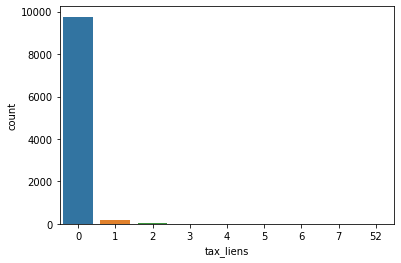

public_record_bankrupt


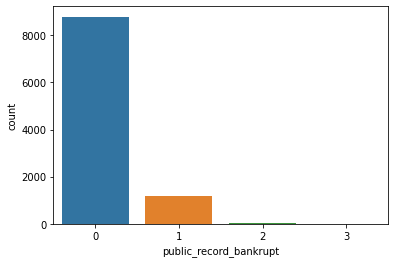

term


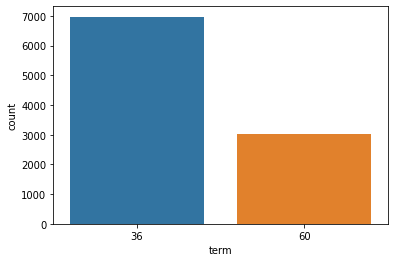

delinq_2y


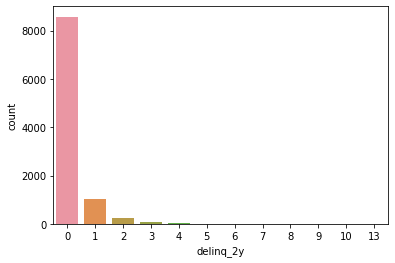

current_accounts_delinq


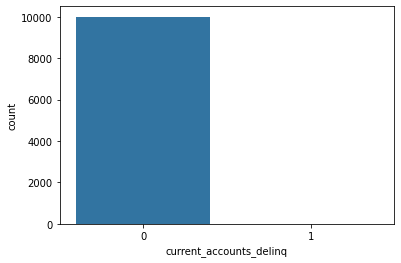

In [7]:
for col in possible_features:
    if len(df[col].value_counts()) < 25 and (not col.startswith('num')):
        print(col)
        sns.countplot(x=df[col])
        plt.show()

- tax_liens: A numeric vector.
- public_record_bankrupt: Number of bankruptcies listed in the public record for this applicant.
- term: The number of months of the loan the applicant received.
- delinq_2y: Delinquencies on lines of credit in the last 2 years.
- current_accounts_delinq: Number of accounts where the applicant is currently delinquent.

In [8]:
df['current_accounts_delinq'].value_counts()

0    9999
1       1
Name: current_accounts_delinq, dtype: int64

It seems that none of these are misclassified as numeric data.
But we do found two issue columns:
1. term: only consists of "36" and "60", might be considered as categorical data.
2. current_accounts_delinq: only have 1 row as "1", others are all "0", might be meaningless for prediction.

In [9]:
df['term'] = df['term'].astype('category')
df.drop(columns='current_accounts_delinq', inplace=True)

## Visualizations

**1. What are the purpose of loans accepted?**

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11]),
 [Text(0, 0, 'debt_consolidation'),
  Text(1, 0, 'credit_card'),
  Text(2, 0, 'other'),
  Text(3, 0, 'home_improvement'),
  Text(4, 0, 'major_purchase'),
  Text(5, 0, 'medical'),
  Text(6, 0, 'house'),
  Text(7, 0, 'car'),
  Text(8, 0, 'small_business'),
  Text(9, 0, 'moving'),
  Text(10, 0, 'vacation'),
  Text(11, 0, 'renewable_energy')])

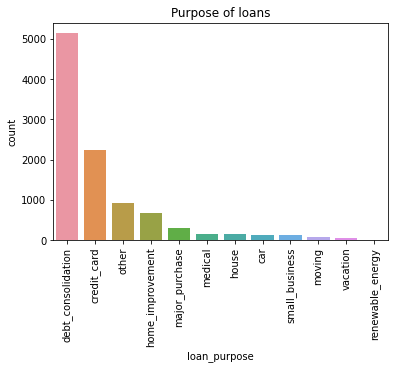

In [10]:
# plt.figure(dpi=100)
sns.countplot(x=df['loan_purpose'], order=df['loan_purpose'].value_counts().index)
plt.title('Purpose of loans')
plt.xticks(rotation=90)

We can see that the majority of loans are for debt_consolidation and credit_card, while the least is renewable_energy.

**2. What job titles do loans prefer/accepted, or who is borrowing the money.**

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),
 [Text(0, 0, 'manager'),
  Text(1, 0, 'owner'),
  Text(2, 0, 'teacher'),
  Text(3, 0, 'driver'),
  Text(4, 0, 'sales'),
  Text(5, 0, 'registered nurse'),
  Text(6, 0, 'rn'),
  Text(7, 0, 'supervisor'),
  Text(8, 0, 'truck driver'),
  Text(9, 0, 'office manager')])

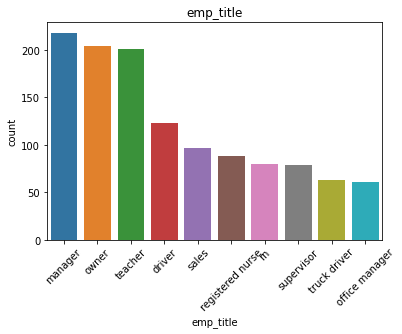

In [11]:
# plt.figure(dpi=100)
sns.countplot(x=df['emp_title'], order=df['emp_title'].value_counts().iloc[:10].index)
plt.title('emp_title')
plt.xticks(rotation=45)

Manager, Owner and teacher are those who are borrowing the money, and the loans are accepted.

**3. Amount of loans in each states map.**

In [ ]:
map_df = df.groupby('state').agg({"loan_amount": 'sum'})
fig = px.choropleth(locations=map_df.index, 
                    locationmode="USA-states", 
                    scope="usa",
                    color=map_df['loan_amount'],
                    color_continuous_scale="greens", 
                    )
fig.show()

<img src="newplot.png" />

We can see that California, Texas, New York, and Florida have the most amount of loans.

Probably related to states’ economic output, such as GDP

**4. Distribution of interest rate**

<AxesSubplot:xlabel='interest_rate'>

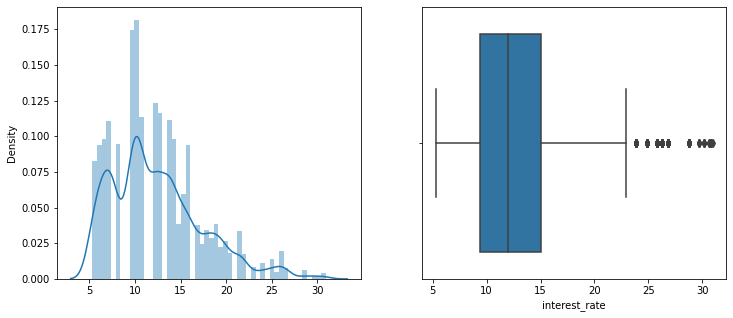

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(12,5))
sns.distplot(x=df['interest_rate'], ax=axes[0])
sns.boxplot(x=df['interest_rate'], ax=axes[1])

We can see that the interest rate varies from around 5 to 30, with a right-skewed distribution, peak at around 12.

**5. Interest Rate by Grade**

Text(0.5, 1.0, 'Interest rate by grade')

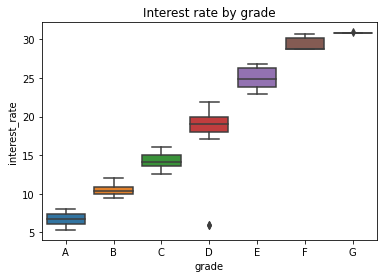

In [14]:
grade_df = df.groupby('grade').agg({"interest_rate": "mean"})
# plt.figure(dpi=100)
sns.boxplot(x=df['grade'], y=df['interest_rate'], order=grade_df.index)
plt.title('Interest rate by grade')

We can see that lower letter grade get higher interest rate.

**6.Heatmap for correlation matrix for interest_rate**

,interest_rate
debt_to_income,0.141653
earliest_credit_line,0.103635
inquiries_last_12m,0.131193
total_credit_limit,-0.130497
accounts_opened_24m,0.120657
months_since_last_credit_inquiry,-0.100945
total_debit_limit,-0.254225
num_mort_accounts,-0.138351
account_never_delinq_percent,-0.124702
interest_rate,1.000000


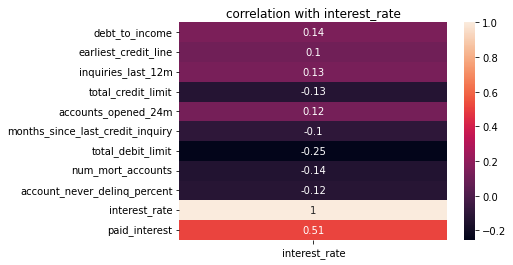

In [15]:
corr = df.corr()[['interest_rate']]
corr = corr[corr['interest_rate'].abs() > 0.1]
# vmin, vmax = corr.min(), corr.max()
# plt.figure(dpi=100, figsize=(8, 6))
# plt.figure(dpi=100)
sns.heatmap(corr, annot=True)
plt.title('correlation with interest_rate')
corr

It seems that only paid_interest have correlation greater than 0.5

## Create a feature set and create a model which predicts interest_rate

Transfer all object to categorical

In [16]:
obj_cols = df.columns[df.dtypes == "object"]
obj_cols
for col in obj_cols:
    df[obj_cols] = df[obj_cols].astype("category")

Categorical variables vs interest_rate

In [17]:
cols = df.columns[df.dtypes == "category"]
cols

Index(['emp_title', 'state', 'homeownership', 'verified_income',
       'loan_purpose', 'application_type', 'term', 'grade', 'sub_grade',
       'issue_month', 'loan_status', 'initial_listing_status',
       'disbursement_method'],
      dtype='object')

In [18]:
cate_cols = []
for col in cols:
    if len(df[col].value_counts()) < 30:
        cate_cols.append(col)
cate_cols

['homeownership',
 'verified_income',
 'loan_purpose',
 'application_type',
 'term',
 'grade',
 'issue_month',
 'loan_status',
 'initial_listing_status',
 'disbursement_method']

homeownership


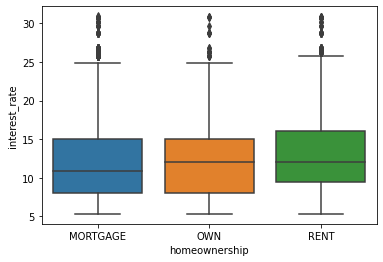

verified_income


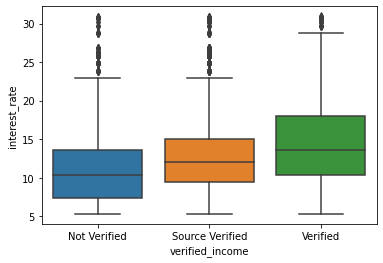

loan_purpose


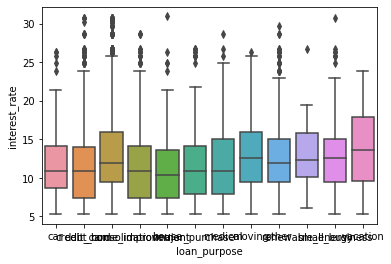

application_type


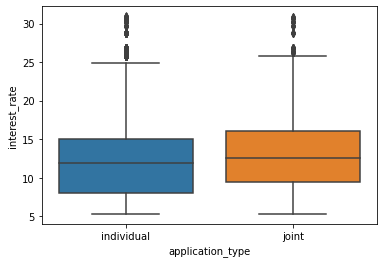

term


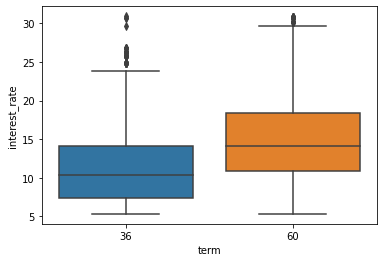

grade


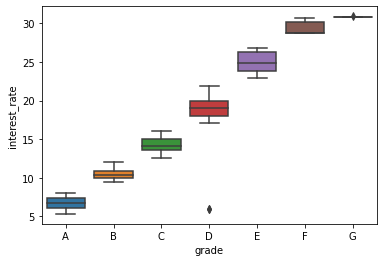

issue_month


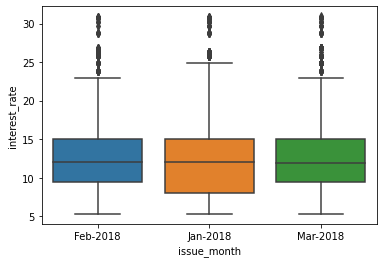

loan_status


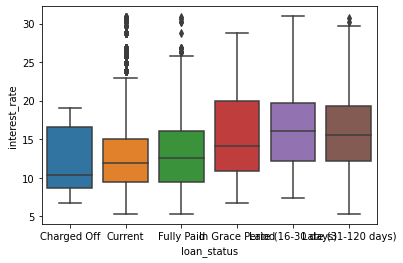

initial_listing_status


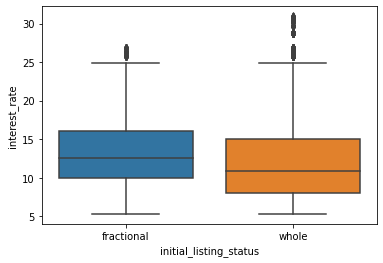

disbursement_method


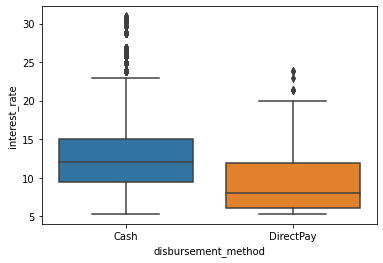

In [19]:
for col in cate_cols:
    print(col)
    temp_df = df.groupby(col).agg({"interest_rate": "mean"})
    sns.boxplot(x=df[col], y=df['interest_rate'], order=temp_df.index)
    plt.show()

**Feature set chosen:**
- Numeric: paid_interest, debt_to_income, inquiries_last_12m
- Categorical: grade, term, disbursement_method

**Drop null values.**

In [20]:
feature_df = df[['paid_interest', 'debt_to_income', 'inquiries_last_12m', 'grade', 'term', 'disbursement_method', 'interest_rate']]
feature_df = feature_df.dropna()
feature_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9976 entries, 0 to 9999
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype   
---  ------               --------------  -----   
 0   paid_interest        9976 non-null   float64 
 1   debt_to_income       9976 non-null   float64 
 2   inquiries_last_12m   9976 non-null   int64   
 3   grade                9976 non-null   category
 4   term                 9976 non-null   category
 5   disbursement_method  9976 non-null   category
 6   interest_rate        9976 non-null   float64 
dtypes: category(3), float64(3), int64(1)
memory usage: 419.5 KB


<AxesSubplot:xlabel='paid_interest'>

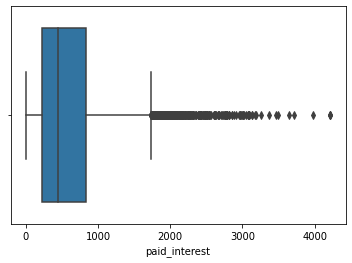

In [21]:
sns.boxplot(x=feature_df["paid_interest"])

<AxesSubplot:xlabel='debt_to_income'>

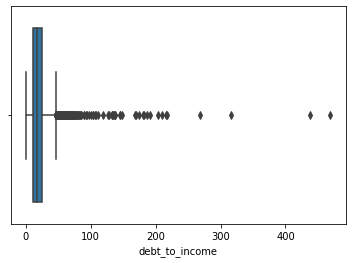

In [22]:
sns.boxplot(x=feature_df["debt_to_income"])

<AxesSubplot:xlabel='inquiries_last_12m'>

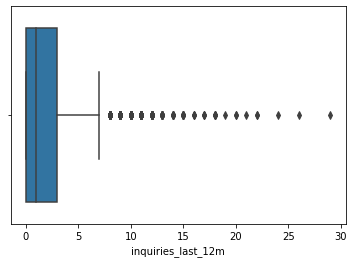

In [23]:
sns.boxplot(x=feature_df["inquiries_last_12m"])

**Handle Categorical variables**

In [24]:
feature_df['grade'] = feature_df['grade'].cat.reorder_categories(['A', 'B', 'C', 'D', 'E', 'F', 'G'], ordered=True)
feature_df['grade'] = feature_df['grade'].cat.codes

In [25]:
feature_df['term']= feature_df['term'].cat.reorder_categories([36, 60], ordered=True)
feature_df['term'] = feature_df['term'].cat.codes

In [26]:
feature_df['disbursement_method']= feature_df['disbursement_method'].cat.reorder_categories(['DirectPay', 'Cash'], ordered=True)
feature_df['disbursement_method'] = feature_df['disbursement_method'].cat.codes

In [27]:
feature_df.head()

,paid_interest,debt_to_income,inquiries_last_12m,grade,term,disbursement_method,interest_rate
0,1015.19,18.01,6,2,1,1,14.07
1,150.49,5.04,1,2,0,1,12.61
2,106.43,21.15,4,3,0,1,17.09
3,566.15,10.16,0,0,0,1,6.72
4,754.80,57.96,7,2,0,1,14.07


**1. Using Multiple Linear Regression**

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = feature_df[['paid_interest', 'debt_to_income', 'inquiries_last_12m', 'grade', 'term', 'disbursement_method']]
y = feature_df[['interest_rate']]


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=36)
LR = LinearRegression()
LR.fit(X_train, y_train)
y_prediction =  LR.predict(X_test)

print("r2 socre", r2_score(y_test, y_prediction))
print("mean_sqrd_error(MSE): ",mean_squared_error(y_test, y_prediction))

r2 socre 0.9367055421983439
mean_sqrd_error(MSE):  1.549933574576568


**2. Using Decision Tree**

In [30]:
from sklearn.tree import DecisionTreeRegressor

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=36)
DT = DecisionTreeRegressor()
DT.fit(X_train, y_train)
y_prediction =  DT.predict(X_test)

print("r2 socre", r2_score(y_test, y_prediction))
print("mean_sqrd_error(MSE): ",mean_squared_error(y_test, y_prediction))

r2 socre 0.8970563549502827
mean_sqrd_error(MSE):  2.5208496492985986


## Evaluation and future improvements

**Visualization for Linear Regression**

In [31]:
import statsmodels.api as sm
from statsmodels.formula.api import ols

fit = ols('interest_rate ~ paid_interest + debt_to_income + inquiries_last_12m + grade + term + disbursement_method', data=feature_df).fit()
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          interest_rate   R-squared:                       0.941
Model:                            OLS   Adj. R-squared:                  0.941
Method:                 Least Squares   F-statistic:                 2.646e+04
Date:                Tue, 12 Apr 2022   Prob (F-statistic):               0.00
Time:                        04:26:20   Log-Likelihood:                -16097.
No. Observations:                9976   AIC:                         3.221e+04
Df Residuals:                    9969   BIC:                         3.226e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
=======================================================================================
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
Intercept               6.0287      0.050    120.905      0.000       5.931       6.126
paid_interest           0.0004   2.92e-05     12.399      0.000       0.000       0.000
debt_to_income          0.0031      0.001      3.738      0.000       0.001       0.005
inquiries_last_12m      0.0185      0.005      3.580      0.000       0.008       0.029
grade                   4.1234      0.013    324.686      0.000       4.098       4.148
term                   -0.0370      0.030     -1.213      0.225      -0.097       0.023
disbursement_method     0.1794      0.048      3.741      0.000       0.085       0.273
==============================================================================
Omnibus:                      517.837   Durbin-Watson:                   1.991
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2028.261
Skew:                          -0.000   Prob(JB):                         0.00
Kurtosis:                       5.209   Cond. No.                     4.34e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.34e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1
eval_env: 1


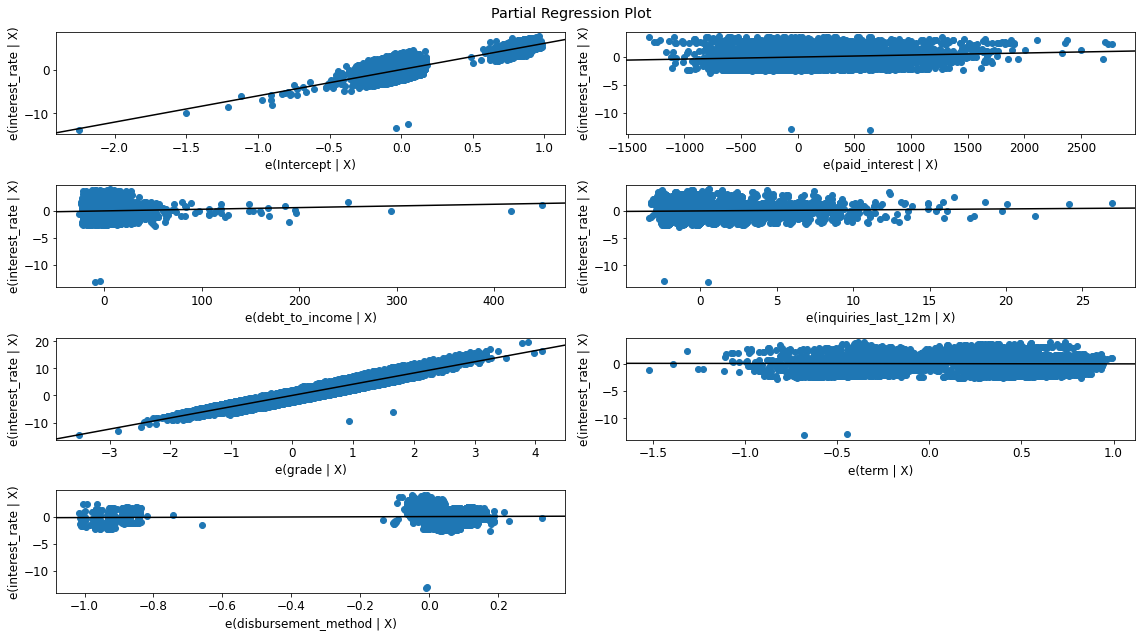

In [32]:
plt.rc("figure", figsize=(16, 9))
plt.rc("font", size=12)
fig = sm.graphics.plot_partregress_grid(fit)
fig.tight_layout(pad=1.0)

**Visualization for Decision Tree**

In [33]:
import shap

explainer = shap.TreeExplainer(DT)
shap_values = explainer.shap_values(X_test)

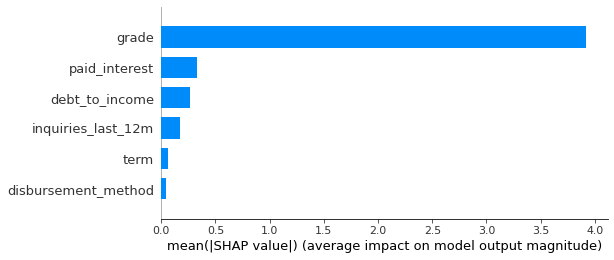

In [34]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

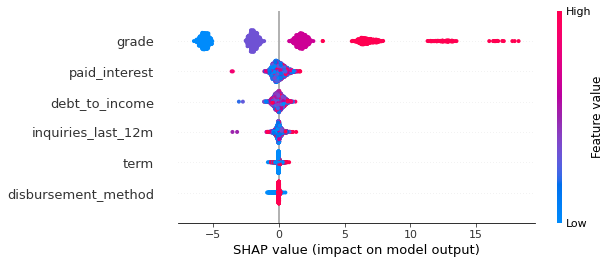

In [35]:
shap.summary_plot(shap_values, X_test)

Although it seems that the Multiple Linear Regression and Decision Tree works well, with an r2 score of nearly 0.9 and low MSE. We can see that our models are all largely dependent on grade, which is reasonably the most obvious indicator of interest_rate.

We have made some assumptions using these models, without having time to check them.

**Some assumptions:**
- There are no outliers.
- For linear model, we assume the relationships are linear.
- We did not check the relationships inbetween input variables, we assume they are independent.

**Some future improvements:**
- Try more features combinations, with the implementation of dimension reduction methods like PCA and further analysis.
- Figure out linear and non-linear relationships.
- Deal with outliers, more data cleaning.
- Using Random Forest instead of Decision Tree to solve the possible issue of overfit.
- Try with other models, such as Neural Network and K-Nearest Neighbors (KNN).